# 00 IMPORTS

In [1]:
import warnings

import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

from IPython.display      import Image
from IPython.core.display import HTML

import bisect
import inflection

## 0.1 Load Dataset

In [2]:
dfRaw = pd.read_csv('../../01-Data/churn.csv')

In [3]:
dfRaw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 0.2 Helper Functions

### 0.2.1 Jupyter Config

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 0
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.2.1 Functions

In [6]:
def group_age(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def mlScores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    ap = average_precision_score(y, yhatProba)
    roc_auc = roc_auc_score(y, yhatProba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Average Precision Score': ap,
                           'ROC AUC': roc_auc}, index=[0])



def crossValidation(X_training, kfold, model_name, model, verbose=False):
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    ap_list = []
    roc_auc_list = []
    X_training = X_training.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['Exited'], axis=1)
        y_kfold_training = training['Exited']

        # Validation
        X_kfold_validation = validation.drop(['Exited'], axis=1)
        y_kfold_validation = validation['Exited']
        
        #Model
        model.fit(X_kfold_training, y_kfold_training)

        # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]

        #Performance
        model_result = mlScores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
    

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

# 1.0 DESCRIPTION

In [7]:
df01 = dfRaw.copy()

## 1.1 Columns

In [8]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### 1.1.1 Rename Columns

In [9]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

#### 1.1.1.1 New Name Columns

In [12]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.2 Data Dimensions

In [13]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


## 1.3 Data Types

In [14]:
df01.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

### 1.3.1 Change Types

In [15]:
## Convert Objects type to categorical types >> more performatic
df01[df01.select_dtypes(include=['object']).columns] = df01.select_dtypes(include=['object']).astype('category')

## Convert Boolean integer columns to Boolean
df01[['has_cr_card', 'is_active_member', 'exited']] = df01[['has_cr_card', 'is_active_member', 'exited']].astype('bool')

In [16]:
df01.dtypes

row_number             int64
customer_id            int64
surname             category
credit_score           int64
geography           category
gender              category
age                    int64
tenure                 int64
balance              float64
num_of_products        int64
has_cr_card             bool
is_active_member        bool
estimated_salary     float64
exited                  bool
dtype: object

## 1.4 Not a Number

### 1.4.1 Sum

In [17]:
df01.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### 1.4.2 ~~Fillout NA~~

there is no NA values

## 1.5 Descriptive Statistical

In [18]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
not_numerial = ['row_number', 'customer_id']
num_attributes = num_attributes[num_attributes.columns[~num_attributes.columns.isin(not_numerial)]]

#Categorical Attributes
cat_attributes = df01.select_dtypes(include=['category'])

#Boolean Attributes
bool_attributes = df01.select_dtypes(include=['bool'])

### 1.5.1 Numerical Attributes

In [19]:
### Central Tendency -> Mean, Median, Mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
ct3.columns = ct1.columns

### Dispersion -> std, min, max, range, skew, kurtosis, rsd
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
d7 = d1 / ct1



# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2,ct3, d1, d7, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Mode', 'Std','Relative Std', 'Skew', 'Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Mode,Std,Relative Std,Skew,Kurtosis
0,credit_score,350.00,850.00,500.00,650.528800,652.000,850.00,96.648466,0.148569,-0.071607,-0.425726
1,age,18.00,92.00,74.00,38.921800,37.000,37.00,10.487282,0.269445,1.011320,1.395347
2,tenure,0.00,10.00,10.00,5.012800,5.000,2.00,2.892030,0.576929,0.010991,-1.165225
3,balance,0.00,250898.09,250898.09,76485.889288,97198.540,0.00,62394.285254,0.815762,-0.141109,-1.489412
4,num_of_products,1.00,4.00,3.00,1.530200,1.000,1.00,0.581625,0.380098,0.745568,0.582981
5,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,24924.92,57507.617221,0.574558,0.002085,-1.181518


#### 1.5.1.1 Numerical Attributes

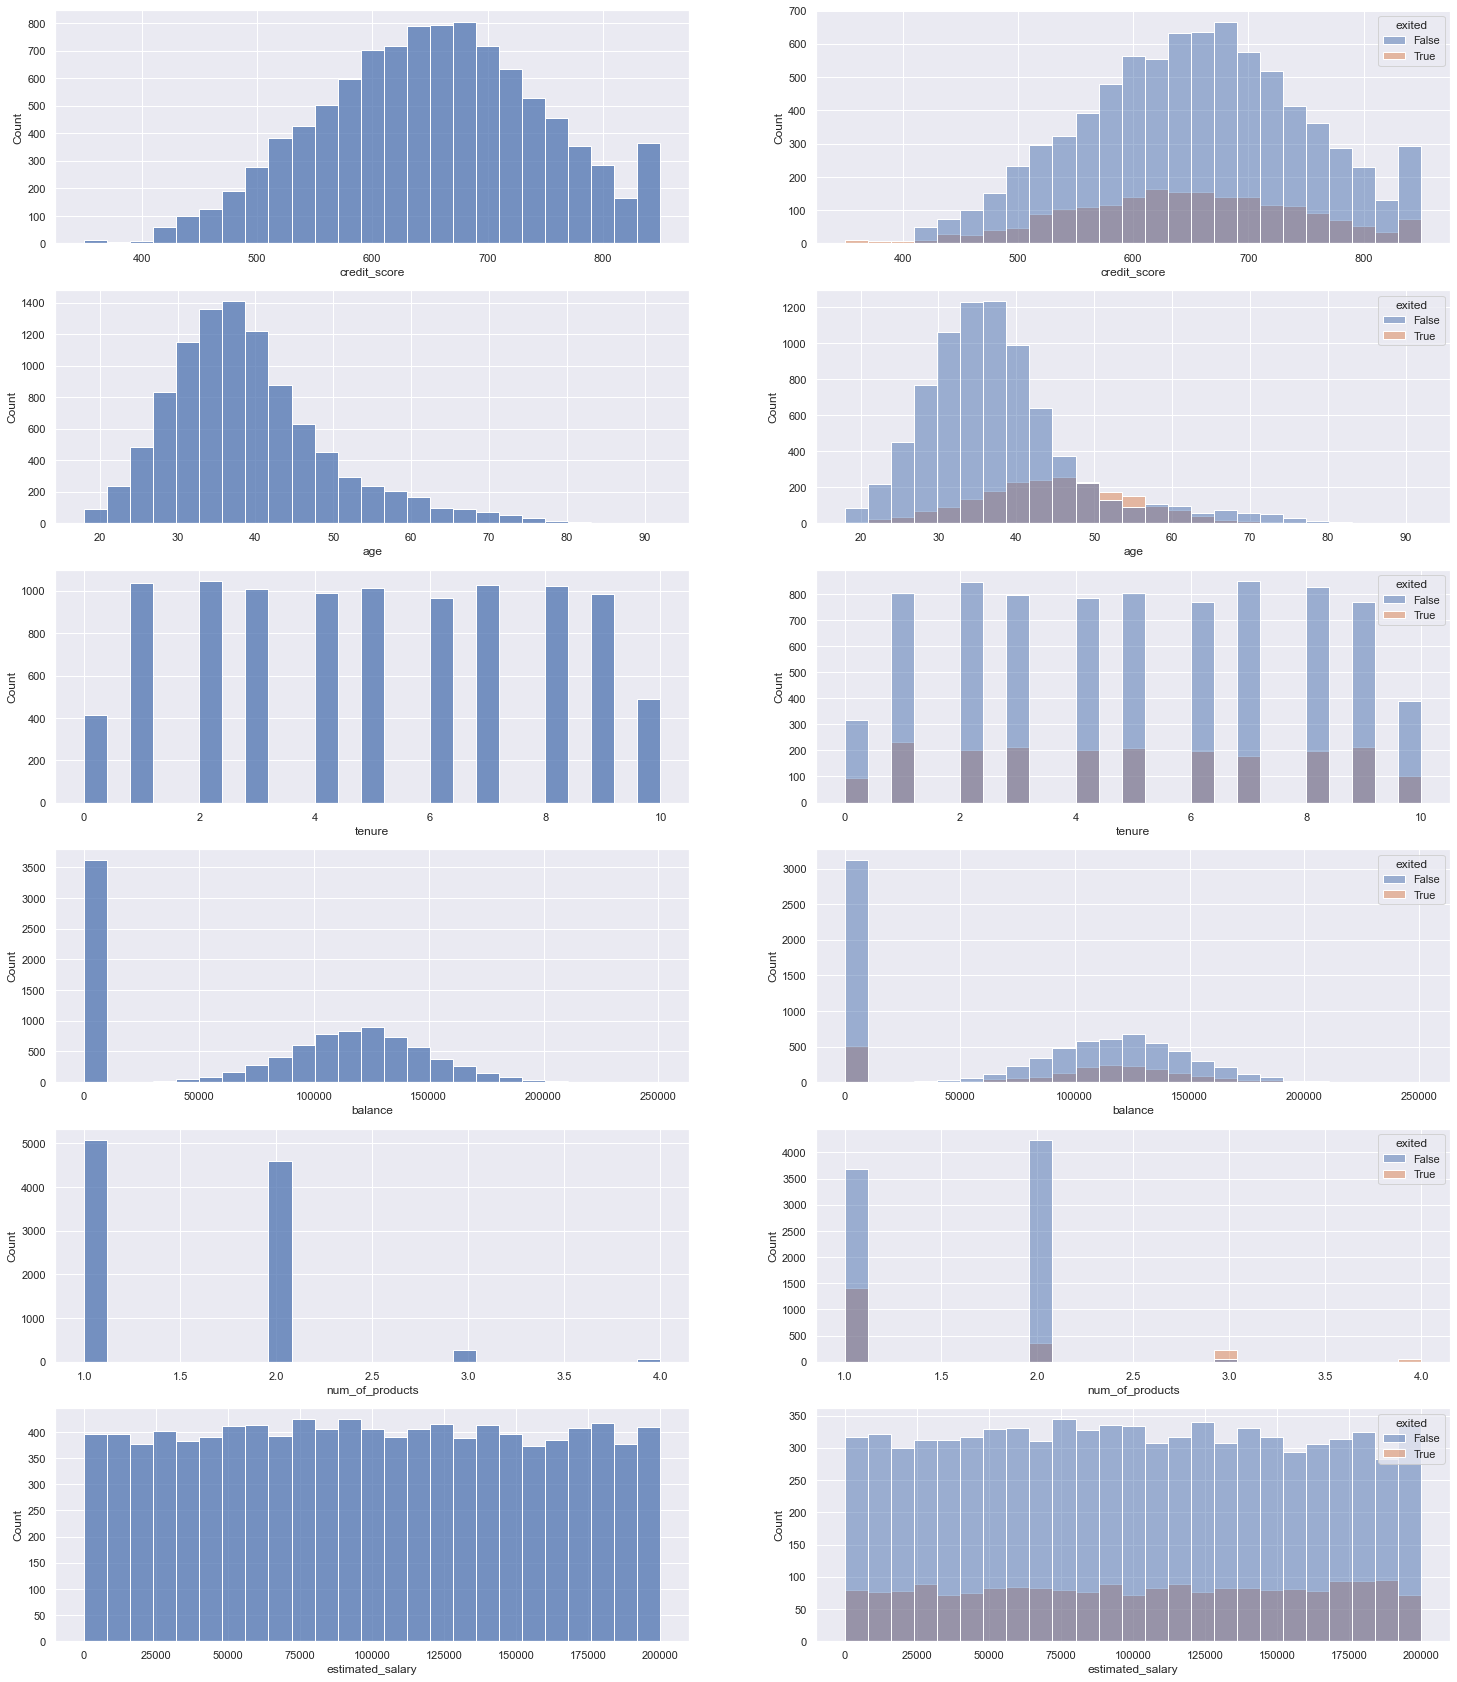

In [20]:
count = 1
attributes_to_inspect = m['Attributes'].tolist()
rows= len(attributes_to_inspect)
plt.figure(figsize=(25,5*rows))
for i in attributes_to_inspect:
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, data=df01)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, hue='exited', data=df01)
    count += 1
plt.show()

#### 1.5.1.2 Some considerations
---
> **CreditScore**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **Age**
>> - The age range is large and it will be interesting to group by bands
>> - According to indices considered to be higher than 0, this distribution does not approach a normal distribution
>
> **Tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>
> **Balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - It's noted the pressure of considered amount of outliers that make the average is lower than the median and that the mode is 0.00, which impacts a lot both the kurtosis and std
>
> **NumOfProducts**
>> - As this attribute is of the whole nature and by the media, median and fashion indices show an unbalanced distribution according to the range
>
> **EstimatedSalary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a distribution with great dispersion

### 1.5.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

surname      2932
geography       3
gender          2
dtype: int64

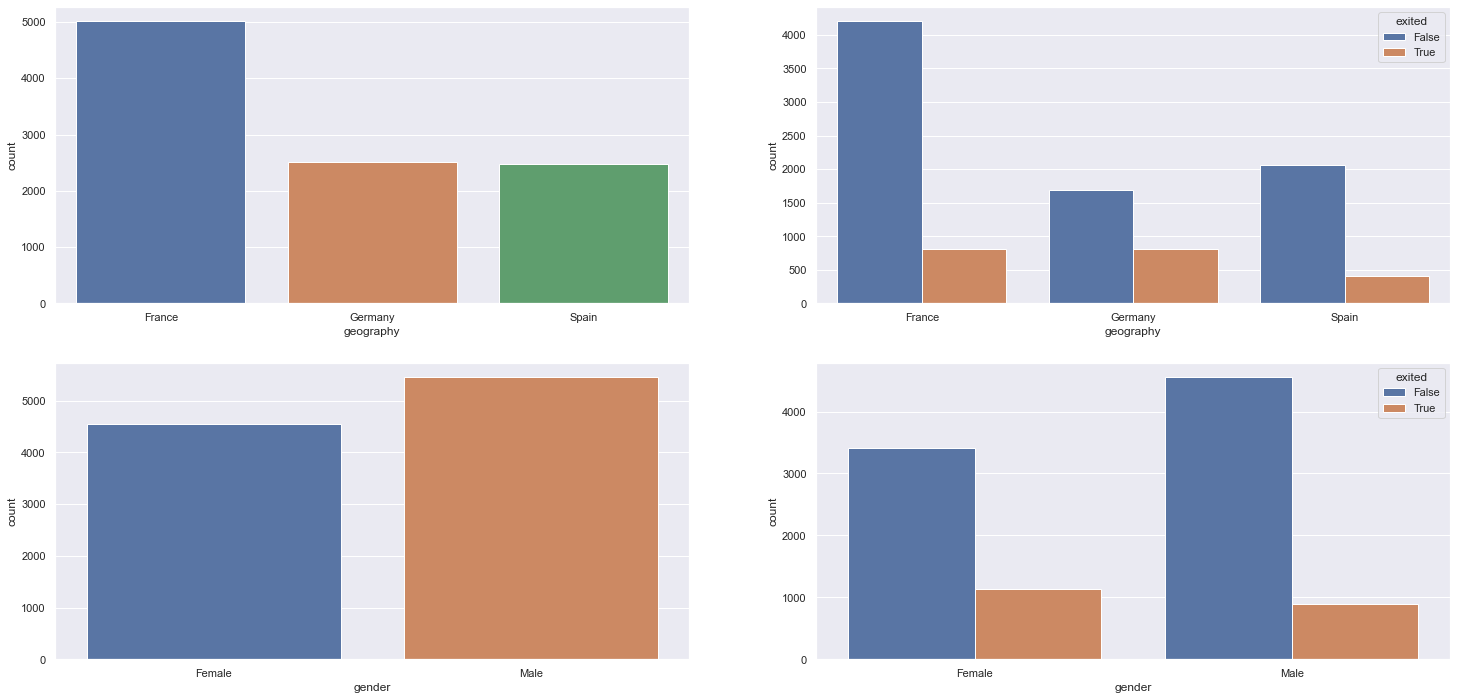

In [22]:
count = 1
attributes_to_inspect = ['geography', 'gender']
rows= len(attributes_to_inspect)
for i in attributes_to_inspect:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df01)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df01)
    count += 1
plt.show()

### 1.5.3 Boolean Attributes

In [23]:
df_bool = pd.DataFrame(bool_attributes.apply(lambda x: x.sum())).rename(columns={0:"Yes"})
df_bool['No'] = df_bool['Yes'].apply(lambda row: df01.shape[0] - row)
df_bool.head()

,Yes,No
has_cr_card,7055,2945
is_active_member,5151,4849
exited,2037,7963


# 2.0 FEATURE ENGINEERING

In [24]:
df02 = df01.copy()

## 2.1 Mind Map

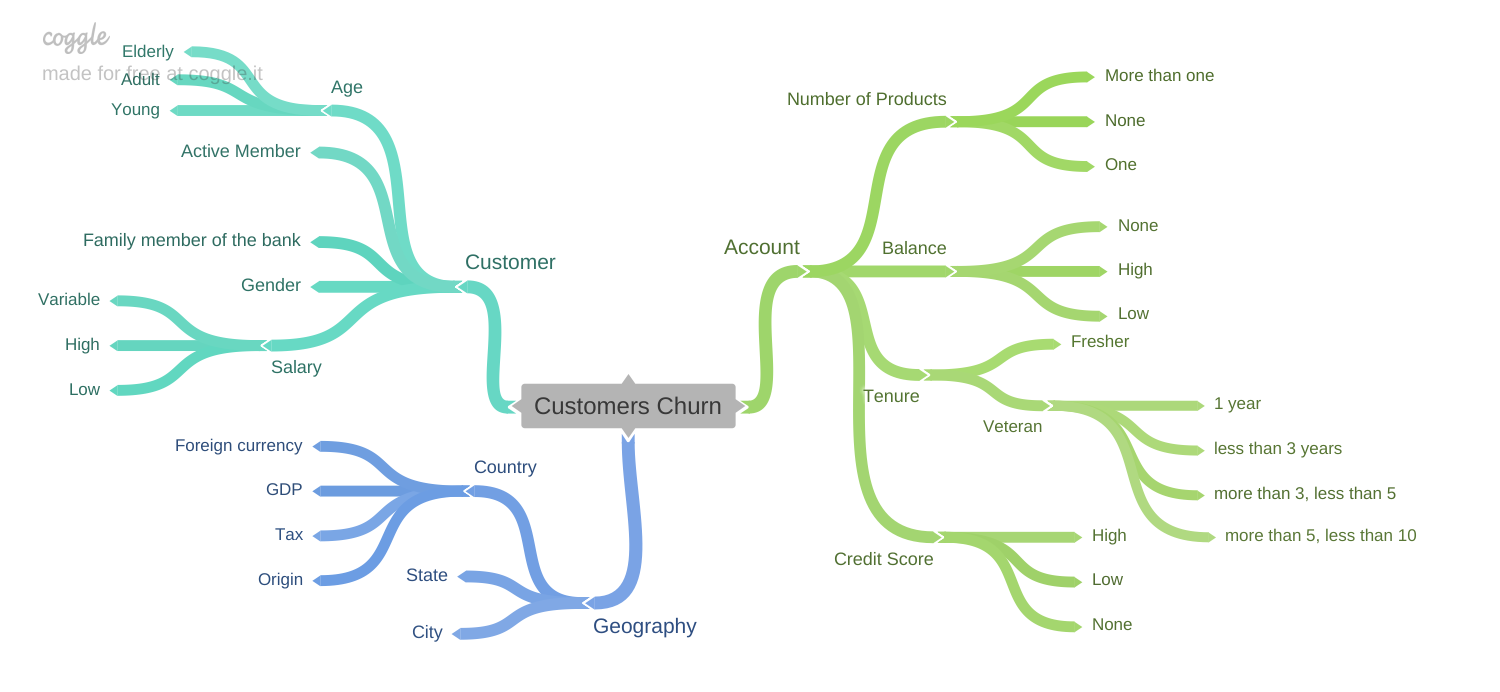

In [25]:
Image('../../img/01-FirstCycleCRISPCostumerChurn.png')

### 2.1.1 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Clients with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Clients with higher estimated wages have higher Churn Rate
>
> **Geography**
>> - H01 - Countries with higher GDP have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin have higher number of churn
>
> **Account**
>> - H01 - Active members have less churn
>> - H02 - Active members have more products
>> - H03 - Active members have more credit score
>> - H04 - Customers with credit cards are more active
>> - H05 - Along the years Churn tends to be lower
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

### 2.1.2 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Women usually buy more products
> - H03 - Younger clients are less loyal and more likely to leave a bank
> - H04 - Clients with higher estimated wages have higher Churn Rate
> - H05 - Countries of Latin origin have higher number of churn
> - H06 - Active members have less churn
> - H07 - Along the years Churn tends to be lower
> - H08 - Customers with Credit Cards tend to stay at the bank
> - H09 - Customers with higher balance remain at the bank

## 2.2 Feature Engineering

In [26]:
# Group Age
df02['age_group'] = df02['age'].apply(lambda row: group_age(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)

## 1.6 Variable Filtering

### 1.6.1 ~~Row Fitering~~

### Columns Filtering

In [27]:
to_drop = ['row_number']
df02.drop(to_drop, axis=1, inplace=True)

In [ ]:
colunas = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']